In [1]:
!pip install contractions
!pip install beautifulsoup4
!pip install nltk
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install numpy
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.5 MB/s eta 0:00:00


**1. Tải bộ dữ liệu**: Các bạn tải bộ dữ liệu IMDB-Dataset.csv

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()


**2. Tiền Xử Lý Dữ Liệu**

In [3]:
import re
import string
import nltk
from bs4 import BeautifulSoup
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

stop = set(stopwords.words('english'))
wl = WordNetLemmatizer()

# Function to clean data
def preprocess_text(text):
    soup = BeautifulSoup(text, "html.parser")  # Removing HTML tags
    text = soup.get_text()
    text = contractions.fix(text)  # Expanding contractions
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text)  # Add space after full stop
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = "".join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])  # lemmatize
    return text

# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-3-0411d49a9d64>:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")  # Removing HTML tags


**3. Phân Tích Thăm Dò**

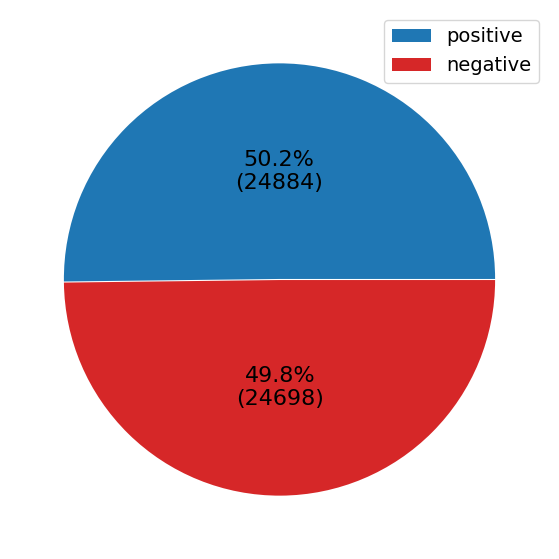

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of positive and negative reviews
freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: "{:.1f}%\n({:d})".format(pct, int(pct / 100. * np.sum(data))),
        explode=[0.0025] * 2, pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})
plt.legend(labels, loc="best", prop={'size': 14})
plt.show()


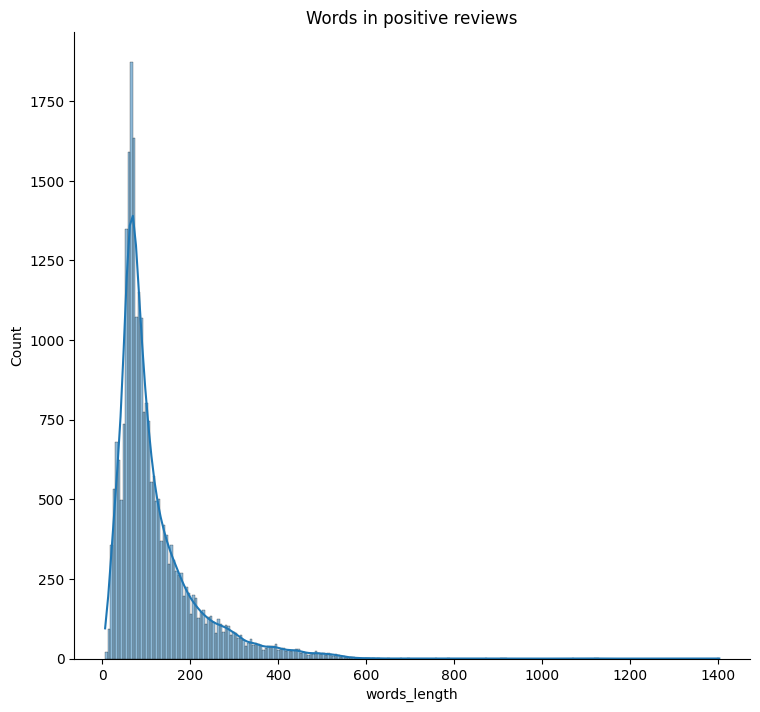

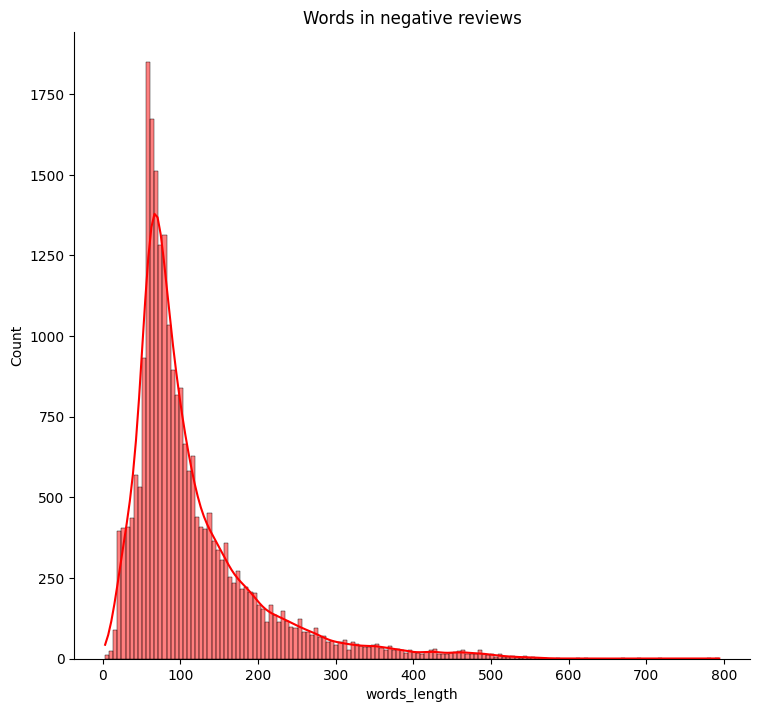

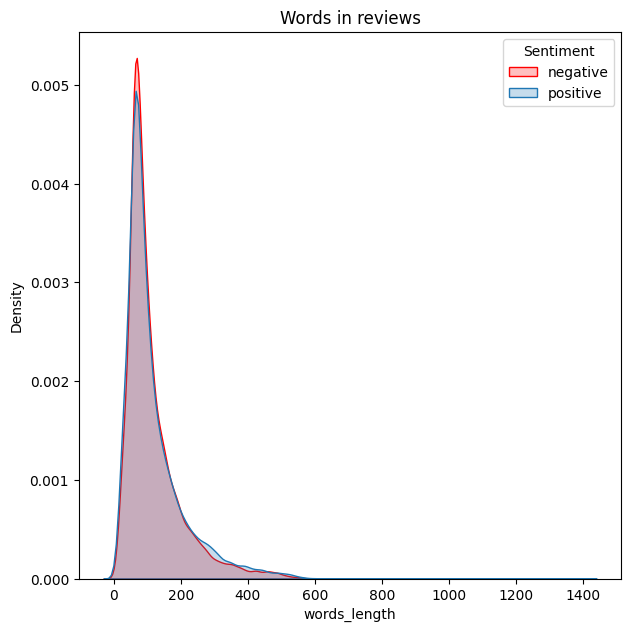

In [11]:
# vẽ các biểu đồ thống kê độ dài của các mẫu review cho mỗi loại cảm xúc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Remove duplicate rows
df = df.drop_duplicates()

# Preprocessing steps (removed for brevity)

# Length statistics of reviews
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words_length'] = words_len

# Plot histogram of word counts for positive reviews
hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words_length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show()

# Plot histogram of word counts for negative reviews
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words_length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show()

# Kernel Density Estimation plot for word count distribution across sentiments
plt.figure(figsize=(7, 7.1))
kernel_distibution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words_length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show()

**4. Chia Dữ Liệu Train/Test**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

# Split data
x_train, x_test, y_train, y_test = train_test_split(df['review'], y_data, test_size=0.2, random_state=42)


**5. Biểu Diễn Văn Bản Thành Vector**

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)


**6. Huấn Luyện và Đánh Giá Mô Hình**

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(x_train_encoded, y_train)
y_pred_dt = dt_classifier.predict(x_test_encoded)

# Evaluate model
accuracy_dt = accuracy_score(y_pred_dt, y_test)
print("Decision Tree Accuracy:", accuracy_dt)


Decision Tree Accuracy: 0.7180598971463145


*Huấn Luyện Random Forest*

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded, y_train)
y_pred_rf = rf_classifier.predict(x_test_encoded)

# Evaluate model
accuracy_rf = accuracy_score(y_pred_rf, y_test)
print("Random Forest Accuracy:", accuracy_rf)


Random Forest Accuracy: 0.8420893415347384
